In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import math as math
from itertools import combinations

Assuming the current asset price $S_0$ is known, then the future price $S_t$ is a random variable with a log-normal distribution

Let $p = q = \frac{1}{2}$, and let $\alpha = \mu + \frac{1}{2} \sigma^2$. <br> <br>
We know from the binomial model, <br>
Equation 1 : $ \mu \Delta t = p \log{u} + q \log{d}$ <br>
Equation 2 : $\sigma \Delta t = \sqrt{pq} \times (\log{u} - \log{d})$ <br> <br>
Inputing the values of $p, q$ <br> 
$\implies \mu \Delta t = \frac{1}{2} \log{u} + \frac{1}{2} \log{d} \equiv  2 \mu \Delta t = \log{u} + \log{d}$ and <br> 
$\implies \sigma \Delta t = \frac{1}{2} \log{u} - \frac{1}{2} \log{d} \equiv 2 \sigma \Delta t = \log{u} - \log{d} $ <br> <br>
Adding (1) and (2), we get : <br> 
$2 \log{u} = 2(\mu \Delta t + \sigma \Delta t) \equiv u = e^{\Delta t(\mu + \sigma)}$ <br> <br>
Similarly subtracting (!) and (2), <br> 
$\log{d} = 2 \mu \Delta t - \Delta t (\mu + \sigma) \equiv d = e^{\Delta t(\mu - \sigma)}$ <br> <br>
Finally, <br> <br>
$u = e^{\Delta t(\mu + \sigma)}$ <br> <br>
$d = e^{\Delta t(\mu - \sigma)}$

In [4]:
# variables 
N = 252 # delta-t is 1 trading day 
S_init = 100 # initial stock price 
T = 1.0
delta_t = T/N 
sigma = 0.3 # annualized volatility
alpha = 0.1 # mean rate of return
u = np.exp(sigma * math.sqrt(delta_t)) 
d = np.exp(-sigma * math.sqrt(delta_t))
mu = alpha - 0.5*(sigma ** 2)
p = 0.5 + 0.5 * mu / sigma * np.sqrt(delta_t)

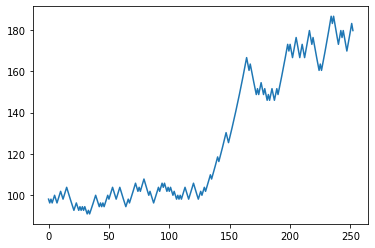

In [7]:
def simulate(curr):
    """ Simulates a random stock price trajectory based on the values for u and d 
    and probability of increase and decrease at each step is p = q = 0.5
    """
    price_history = []
    for i in range(N + 1):
        choices = [curr * u, curr * d]
        curr = np.random.choice(choices, p=[p, 1 - p])
        price_history.append(curr)
    return price_history

plt.plot(simulate(S_init))

In [16]:
price_history = simulate(S_init)

rate_of_return = []
for i in range(1, 252):
    r = (price_history[i] - price_history[i-1]) / price_history[i-1]
    rate_of_return.append(r)
mean_est = np.mean(rate_of_return) * 252
sd_est = pd.Series(rate_of_return).std() * np.sqrt(252)
print("Estimate for alpha is " + str(mean_est))
print("Estimate for sigma is " + str(sd_est))

Estimate for alpha is 0.4814181691090728
Estimate for sigma is 0.2993525383670495


In [17]:
mu_est = mean_est - 0.5*(sd_est**2)
print("Estimate using alpha: " + str(100 * np.exp(mean_est)))
print("Estimate using mu: " + str(100 * np.exp(mu_est)))
print("S_N is " + str(price_history[len(price_history) - 1]))

Estimate using alpha: 161.83678948838997
Estimate using mu: 154.7455854198186
S_N is 154.4436538700964


It is closer to $\mu$. It was closer to $\mu$ more often.

In [18]:
def simulate(alpha, sd):
    mu = alpha - 0.5*(sd**2)
    u = np.exp(sd * np.sqrt(1/252))
    d = np.exp(-sd * np.sqrt(1/252))
    p = 0.5 + 0.5 * mu / sd * np.sqrt(1/252)
    current = 100
    price_history = []
    price_history.append(current)
    for i in range(252):
        choices = [current * u, current * d]
        current = np.random.choice(choices, p=[p, 1 - p])
        price_history.append(current)
    rate_of_return = []
    for i in range(1, 252):
        r = (price_history[i] - price_history[i-1]) / price_history[i-1]
        rate_of_return.append(r)
    mean_est = np.mean(rate_of_return) * 252
    sd_est = pd.Series(rate_of_return).std() * np.sqrt(252)
    return mean_est, sd_est

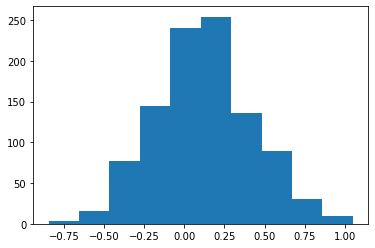

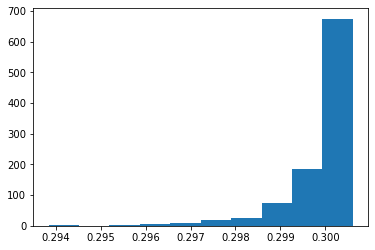

In [19]:
alpha_bars = []
sigma_bars = []
for i in range(1000):
    alpha, sigma = simulate(0.1, 0.3)
    alpha_bars.append(alpha)
    sigma_bars.append(sigma)
plt.hist(alpha_bars)
plt.show()
plt.hist(sigma_bars)
plt.show()

It is clearly difficult to estimate $\alpha$ since there is so much spread (ranges all the way from close to -1 to 1). However, it is much easier to estimate $\sigma$ as most values lie around 0.3, which is the correct value.

binom_call_price is a function that calculates the price of a call option using the binomial
tree model. The function takes as input parameters:
* spot price $S_0$
* strike price $K$
* time to expiration $T$
* number of time steps $N$
* volatility $\sigma$ (annualized)
* risk free rate $r$ (annualized)

In [20]:
def binom_call_price(S_0, K, T, N, vol, r):
    t = T/N # Time step
    # Use CRR parameters
    u = np.exp(vol * np.sqrt(t))
    d = np.exp(-vol * np.sqrt(t))
    # Calculate risk-free probs
    p = (np.exp(r * t) - d)/(u - d)
    q = 1 - p
    
    tree = [] * (N + 1)
    for i in range(N + 1):
        tree.append([-1] * (N + 1))
    
    # Fill out last row
    for i in range(N + 1):
        price = S_0 * (u**(N - i)) * (d**i)
        tree[N][i] = max(0, price - K)

    # Start from end and loop back
    for i in range(N)[::-1]:
        for j in range(i + 1):
            heads = tree[i + 1][j]
            tails = tree[i + 1][j + 1]
            tree[i][j] = (heads * p + tails * q) * np.exp(-t * r)

    return tree[0][0] 

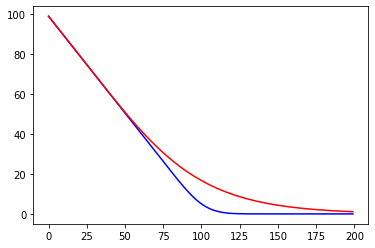

Red is volatility = 0.4 and Blue is volatility = 0.1


In [21]:
call_prices_1 = []
call_prices_2 = []
for i in range(1, 201):
    call_prices_1.append(binom_call_price(100, i, 1, 252, 0.1, 0.03))
    call_prices_2.append(binom_call_price(100, i, 1, 252, 0.4, 0.03))
plt.plot(call_prices_1, 'b')
plt.plot(call_prices_2, 'r')
plt.show()
print("Red is volatility = 0.4 and Blue is volatility = 0.1")

Increase in volatility increases price of option. However, the overall shape of the derivative function doesn't change, so it could be thought of as a "premium".

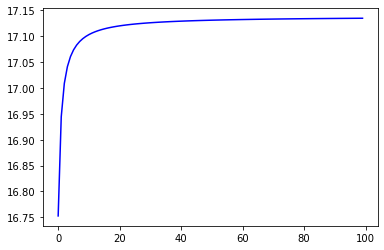

In [22]:
# computing call price with more granular time period
call_prices_N = []
for i in range(1, 101):
    call_prices_N.append(binom_call_price(100, 100, 1, i * 10, 0.4, 0.03))
plt.plot(call_prices_N, 'b')
plt.show()

The Black-Scholes calculator from https://goodcalculators.com/black-scholes-calculator/ returns 17.139. The graph does seem to converge onto that value.